In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv("leaguedata.csv")
df

,game_id,role,kill,death,assist,gold_earned,champion_level,total_damage_dealt,total_damage_dealt_to_champions,vision_score,...,laning_score,is_win,rift_herald_kill,rift_herald_first,dragon_kill,dragon_first,baron_kill,baron_first,tower_kill,horde_kill
0,0.0,my_top,5.0,5.0,12.0,12666.0,17.0,199661.0,38439.0,21.0,...,5.364805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,my_jungle,2.0,4.0,4.0,14072.0,17.0,329327.0,7355.0,31.0,...,5.257720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,my_mid,6.0,8.0,13.0,13334.0,17.0,198326.0,31908.0,15.0,...,5.058014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,my_adc,16.0,9.0,5.0,16681.0,16.0,224340.0,36159.0,16.0,...,4.941986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,my_support,4.0,5.0,9.0,9402.0,14.0,26113.0,8915.0,33.0,...,4.370815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,18.0,enemy_mid,15.0,3.0,3.0,14653.0,16.0,165917.0,25601.0,24.0,...,6.270399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,18.0,enemy_adc,19.0,6.0,15.0,15697.0,15.0,125222.0,39337.0,12.0,...,7.232967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,18.0,enemy_support,12.0,7.0,17.0,10719.0,13.0,37354.0,24711.0,62.0,...,6.686526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,18.0,my_team,NaN,NaN,NaN,49507.0,NaN,NaN,NaN,NaN,...,NaN,False,1.0,True,2.0,True,0.0,False,4.0,3.0


### Important:
It's important to note that I ONLY play jungle, so in all of these models, the jungle section is entirely me.

# This bar chart shows the average gold earned in games that I win.

<Axes: xlabel='role'>

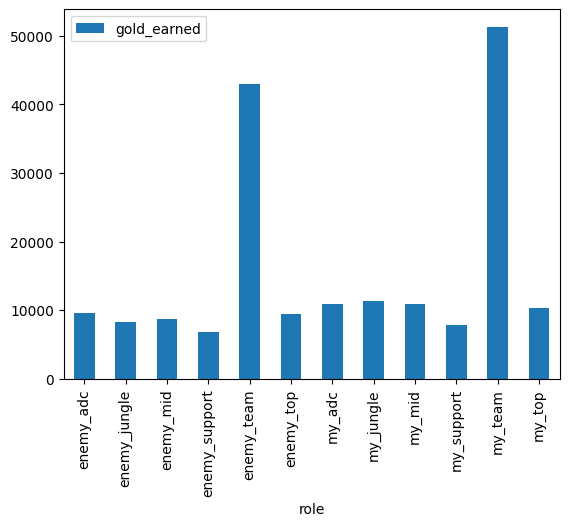

In [20]:
win_game_ids = df.loc[
    (df['role'] == 'my_team') & df['is_win'],
    'game_id'
].unique()
df['i_won'] = df['game_id'].isin(win_game_ids)
df.loc[df['i_won']].groupby(['role', 'i_won'])['gold_earned'].mean().reset_index().plot.bar(
    x="role",
    y="gold_earned"
)

# This bar chart shows the average gold earned in games that I lose

<Axes: xlabel='role'>

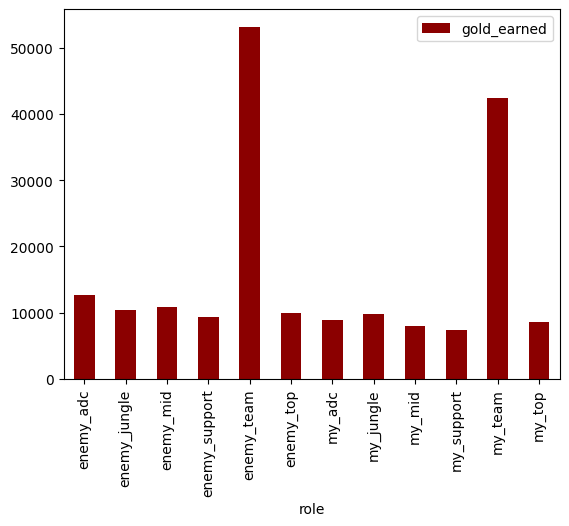

In [4]:
df.loc[~df.i_won].groupby('role').gold_earned.mean().reset_index().plot.bar(
    x = "role",
    y = "gold_earned",
    color = "darkred"
)

# Average difference in gold when I win
As we can easily see, when I win my role has the most amount of gold differential. This is likely because I am usually the **greatest** player on my team, duh.

<Axes: >

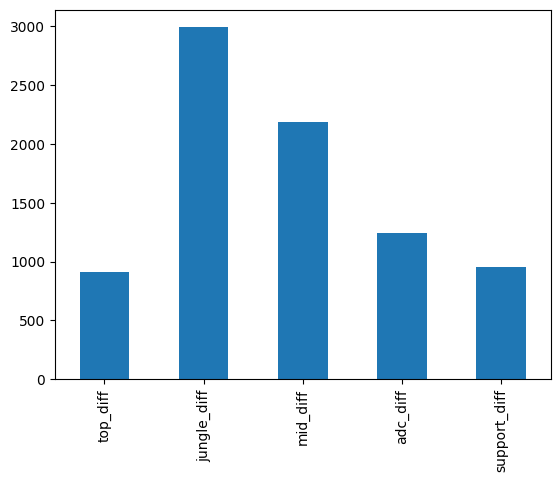

In [5]:
ga = df.loc[df.i_won].groupby('role').gold_earned.mean()
pd.Series([ga.my_top - ga.enemy_top, ga.my_jungle - ga.enemy_jungle, ga.my_mid - ga.enemy_mid, ga.my_adc - ga.enemy_adc, 
           ga.my_support - ga.enemy_support], index = ['top_diff', 'jungle_diff', 'mid_diff', 'adc_diff', 'support_diff']).plot.bar()

# Average difference in gold when I lose
As we can see, when I lose my role has the least amount of gold differential, while the mid and adc roles have much higher differences. This could mean that the adc and mid roles are the most likely to lose the game for the team. However, it could also be explained by the "Snowballing" nature of these roles in the game. Let's look to these role's difference in laning score for more insight later.

<Axes: >

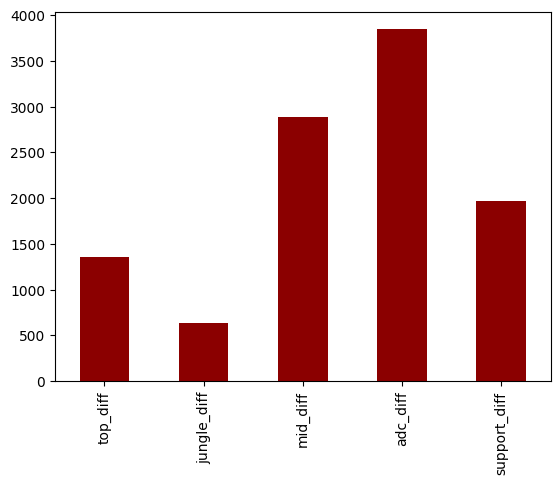

In [6]:
ga = df.loc[~df.i_won].groupby('role').gold_earned.mean()
pd.Series([ga.enemy_top - ga.my_top, ga.enemy_jungle - ga.my_jungle, ga.enemy_mid - ga.my_mid, ga.enemy_adc - ga.my_adc, 
           ga.enemy_support - ga.my_support], index = ['top_diff', 'jungle_diff', 'mid_diff', 'adc_diff', 'support_diff']).plot.bar(color = "darkred")

# This section models the importance of the different objectives on winrate

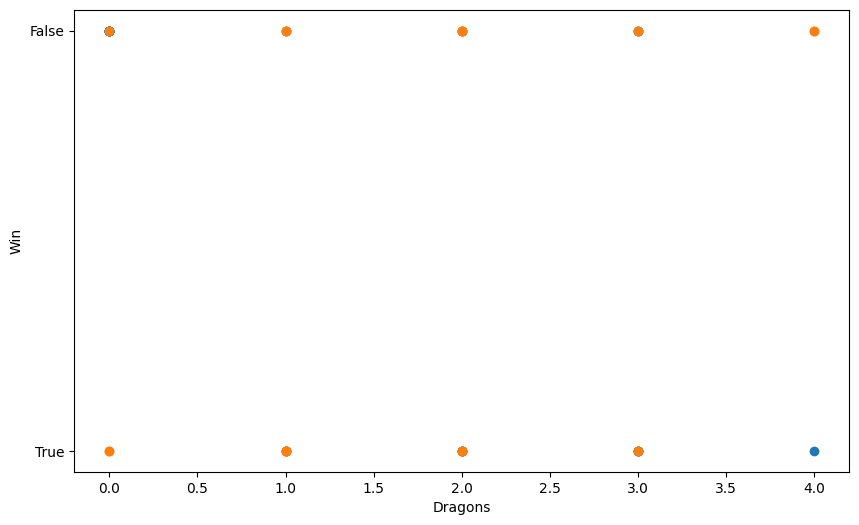

In [7]:
objectives = df.loc[df.role.isin(['my_team', 'enemy_team'])].iloc[:, [1] + [i for i in range(13, 22)]]
enemy = objectives[objectives['role'] == 'enemy_team']
my_team = objectives[objectives['role'] == 'my_team']
plt.figure(figsize=(10, 6))
plt.scatter(my_team['dragon_kill'], my_team['i_won'].apply(lambda x: "True" if x else "False"), label='my_team')
plt.scatter(enemy['dragon_kill'], enemy['i_won'].apply(lambda x: "True" if x else "False"), label='enemy_team')
plt.ylabel('Win')
plt.xlabel('Dragons')
plt.show()

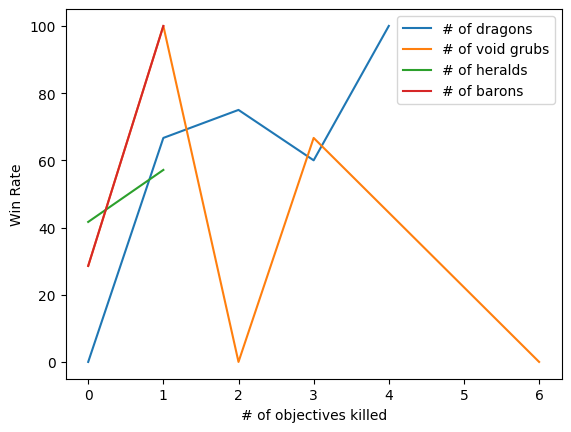

In [24]:
# Winrate based on how many of each objective I get
my_team = df.loc[df.role == 'my_team']
wr_per_dragon = my_team.groupby('dragon_kill').is_win.mean().map(lambda x: x * 100)
wr_per_herald = my_team.groupby('rift_herald_kill').is_win.mean().map(lambda x: x * 100)
wr_per_grub = my_team.groupby('horde_kill').is_win.mean().map(lambda x: x * 100)
wr_per_baron = my_team.groupby('baron_kill').is_win.mean().map(lambda x: x * 100)
plt.plot(wr_per_dragon, label='# of dragons')
plt.plot(wr_per_grub, label='# of void grubs')
plt.plot(wr_per_herald, label='# of heralds')
plt.plot(wr_per_baron, label='# of barons')

plt.xlabel('# of objectives killed')
plt.ylabel('Win Rate')
plt.legend()
plt.show()

[57.14285714285714, 70.0, 100.0]


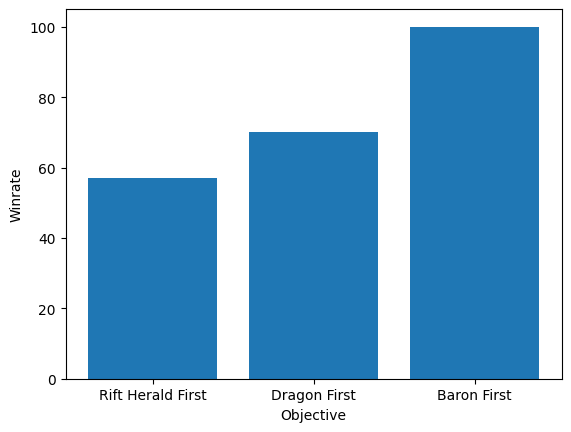

In [9]:
# winrates based on getting objectives first
objectives_first = objectives.loc[objectives.role == 'my_team', ['rift_herald_first', 'dragon_first', 'baron_first', 'i_won']]
objective_winrate_list = []
for i in range(3):
    objective_winrate_list.append(objectives_first.loc[objectives_first.iloc[:, i] == True].i_won.mean() * 100)
plt.bar(x = ['Rift Herald First', 'Dragon First', 'Baron First'], height = objective_winrate_list)
plt.ylabel('Winrate')
plt.xlabel('Objective')
plt.show()

<Axes: xlabel='role'>

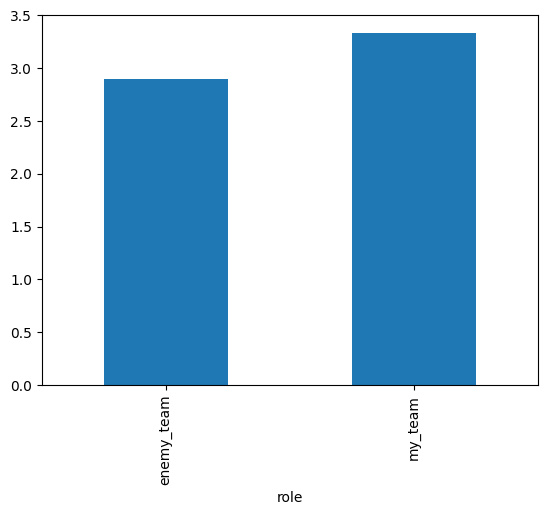

In [37]:
# Average number of objectives that are taken in wins/losses
# WORK ON THIS NEXT, TRY TO DO A STACKED BAR PLOT
win_objectives = objectives.loc[objectives.i_won, ['role', 'rift_herald_kill', 'dragon_kill', 'baron_kill']].groupby('role').mean().sum(axis=1)
lose_objectives = objectives.loc[~objectives.i_won, ['role', 'rift_herald_kill', 'dragon_kill', 'baron_kill']].groupby('role').mean().sum(axis=1)
plt.bar(x=["Enemy Team's Objectives", "My Team's Objectives"], height = [win_objectives, lose_objectives])
plt.show()

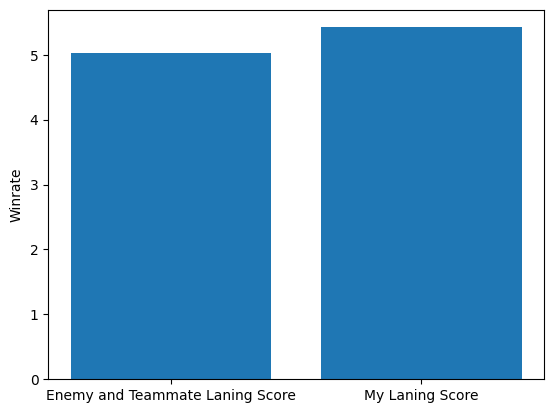

In [16]:
# Average laning score of all my teammates compared to my own
average_score = df.loc[~df.role.isin(['my_jungle', 'my_team', 'enemy_team'])].laning_score.mean()
my_average = df.loc[df.role == 'my_jungle'].laning_score.mean()
plt.bar(x = ['Enemy and Teammate Laning Score', 'My Laning Score'], height = [average_score, my_average])
plt.ylabel('Winrate')
plt.